# 0. Import necessary packages

In [18]:
import pandas as pd
import os
import numpy as np
from sklearn.model_selection import KFold, StratifiedKFold, cross_validate
from sklearn import preprocessing
from sklearn import svm
from sklearn import metrics
from sklearn.model_selection import train_test_split, GridSearchCV, learning_curve
import matplotlib.pyplot as plt

from google.colab import drive

## 0.1. Connect to Google Drive to be able to load files from it

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [3]:
%cd '/content/drive/MyDrive/[REGINNA]UseCaseMachineLearning'

/content/drive/MyDrive/[REGINNA]UseCaseMachineLearning


# 1. About the data we are going to use

The dataset we are using in this experiment is described as:

> _This dataset comes from research by Semeion, Research Center of Sciences of Communication. The original aim of the research was to correctly classify the type of surface defects in stainless steel plates, with six types of possible defects (plus "other"). The Input vector was made up of 27 indicators that
approximately describe the geometric shape of the defect and its outline.

    'X_Minimum', 'X_Maximum', 'Y_Minimum', 'Y_Maximum': These are likely the coordinates of the bounding box of the defect in the image.

    'Pixels_Areas': This could represent the total number of pixels that make up the defect.

    'X_Perimeter', 'Y_Perimeter': These might represent the perimeter of the defect in the X and Y directions.

    'Sum_of_Luminosity', 'Minimum_of_Luminosity', 'Maximum_of_Luminosity': These features likely relate to the brightness of the defect. The sum could be the total brightness, while the minimum and maximum could be the darkest and brightest points.

    'Length_of_Conveyer': This might be a feature related to the production process, such as the length of the conveyor belt used in manufacturing.

    'TypeOfSteel_A300', 'TypeOfSteel_A400': These are likely categorical features indicating the type of steel used in the plate.

    'Steel_Plate_Thickness': This is likely a numerical feature indicating the thickness of the steel plate.

    'Edges_Index', 'Empty_Index', 'Square_Index', 'Outside_X_Index', 'Edges_X_Index', 'Edges_Y_Index', 'Outside_Global_Index': These indices could be related to the shape and location of the defect.

    'LogOfAreas', 'Log_X_Index', 'Log_Y_Index': These features might be the logarithmic transformations of 'Pixels_Areas', 'X_Index', and 'Y_Index'.

    'Orientation_Index': This could be a feature indicating the orientation of the defect.

    'Luminosity_Index': This might be an index related to the brightness of the defect.

    'SigmoidOfAreas': This could be a sigmoid transformation of the 'Pixels_Areas' feature.

    'Pastry', 'Z_Scratch', 'K_Scatch', 'Stains', 'Dirtiness', 'Bumps', 'Other_Faults': These features might be binary or categorical, indicating the presence or absence of specific types of defects.


This dataset can be found in: https://www.kaggle.com/datasets/uciml/faulty-steel-plates?resource=download


## In this experiment

To make this example a bit _simpler_, we are going to classify which are the steel plates which have bumps from those which do not have bumps.

Therefore, we have already removed the columns that indicate the other defects from the original dataset.

In the last column of the provided CSV files, the last column (named _Bumps_) indicates whether the steel plate described by the features in the corresponding row has a bump (value __1__) or not (value __0__).

# 1. Load and preprocess the training data

The data will be loaded from the CSV into a pandas dataframe.

To train a classifier, we need feature vectors and the classes separated into different arrays, so we are going to split data (X_train) and classes (y_train) into separated vectors

In [7]:
dir_data = os.path.join('.')

# Define the path where the CSV with the training data is located
data_train_path = os.path.join(dir_data, "faults_train.csv")

# Read training data from that csv file
data_train_df = pd.read_csv(data_train_path)

# See a sample of the training data
data_train_df.head()

# Separates data and labels and convert those dataframes into numpy arrays (it is not compulsory but convenient)
y_train_df = data_train_df[['Bumps']].copy()
X_train_df = data_train_df.copy().drop(columns=['Bumps'])
X_train = X_train_df.to_numpy()
y_train = y_train_df.to_numpy().ravel()

print("% of class 1 elements in the training set: {}".format(np.sum(y_train==1)/len(y_train)))

% of class 1 elements in the training set: 0.21796759941089838


## 1.1. Normalizing training data so that it has mean=0 and std=1

This type of normalization groups the data, which may be scattered around the feature space, around its mean. It is a quite common practice.

It is done through the Python object StandardScaler(). After this normalization, all the variables in the set should have mean 0 and std 1.

In [8]:
# Standardize data
scaler = preprocessing.StandardScaler()
scaler.fit(X_train)

# Transforms the data: each variable (column) is subtracted its mean and divided by its std
X_train_norm = scaler.transform(X_train)

print("TRAINING SET: mean={}; std={}".format(np.mean(X_train_norm), np.std(X_train_norm)))

TRAINING SET: mean=-1.9994759290535115e-17; std=1.0


# 2. Select a classifier and train it

We are going to try the SVM classifier with gaussian kernel and a value for the parameter $C$ of 5.

It will be trained using the training data

In [9]:
# Parameters for SVM
C_value = 5
kernel_type = "rbf"

# Create the instance of the classifier object
SVM_classifier = svm.SVC(kernel=kernel_type, C=C_value)

In [10]:
# TRAIN the classifier
SVM_classifier.fit(X_train_norm, y_train)

SVC(C=5)

### 2.1 Configure GridSearch to find out the best combination of parameters and their values

In [ ]:
# Define the parameter grid to search through
param_grid = {'C': [0.1, 1, 10],
              'kernel': ['linear', 'rbf', 'poly']}

# Perform GridSearchCV
grid_search = GridSearchCV(estimator=SVM_classifier, param_grid=param_grid, cv=5)
grid_search.fit(X_train, y_train)

# Print the best parameters and best score
print("Best Parameters:", grid_search.best_params_)
print("Best Score:", grid_search.best_score_)

# Evaluate the model on the test set
best_model = grid_search.best_estimator_
test_score = best_model.score(X_test, y_test)
print("Test Set Score:", test_score)

# 3. Load and preprocess the test data

Now, let's classify some data which has not been seen before by the classifier.

To make this experiment a bit quicker, I have previously saved some new steel plates descriptors into another CSV file, called "faults_test.csv" (i.e. descriptors that have not been previously seen during training). In this set, we know the real classes, but the classifier will not _see_ them

The test data will be loaded from the corresponding CSV file into a pandas dataframe.

We are going to split data (X_test) and classes (y_test) into separated vectors. The classifier will only process the data X_test. The true classes will only be used for calculating the results of the classification.

In [23]:
# Define the path where the CSV with the test data is located
data_test_path = os.path.join(dir_data, "faults_test.csv")

# Read test data from the csv file
data_test_df = pd.read_csv(data_test_path)

# See a sample of the test data
data_test_df.head()

# Separates test data and labels, and convert those dataframes into numpy arrays (it is not compulsory but convenient)
y_test_df = data_test_df[['Bumps']].copy()
X_test_df = data_test_df.copy().drop(columns=['Bumps'])
X_test = X_test_df.to_numpy()
y_test = y_test_df.to_numpy().ravel()

print("% of class 0 elements in the training set: {}".format(np.sum(y_test==1)/len(y_test)))

% of class 0 elements in the training set: 0.18181818181818182


## 3.1. Normalizing test data

Since the classifier was trained with standardized data, we should also normalize the test data.

To do that, we will use the StandardScaler() object fit with the training data. It stores the means and std of the variables of the training data, and uses them to normalize new samples.
The normalization consists on subtracting to each variable the stored means, and dividing that by the std of such variables.

In [12]:
# Transformation of the data using the StandardScaler object previously used
X_test_norm = scaler.transform(X_test)

print("TEST SET: mean={}; std={}".format(np.mean(X_test_norm), np.std(X_test_norm)))

TEST SET: mean=0.004405604665338881; std=0.9570671834699526


# 4. Classifying the test data and getting the results

## 4.1. The test data is classified

The test data is classified using the trained SVM model (stored in the varibale SVM_model). The output of the classification will be a vector of assigned classes

In [13]:
# Classify the test set and store the predictions into the vector y_test_assig
y_test_assig = SVM_classifier.predict(X_test_norm)

## 4.2. Compare the predictions with the real classes of the test set and print the results

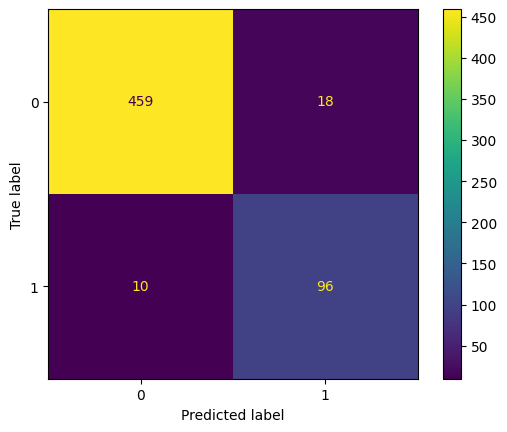

In [14]:
# Show CONFUSION MATRIX
cm = metrics.confusion_matrix(y_test, y_test_assig)
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [15]:
# Show a report with the classification results
# print(metrics.classification_report(y_test, y_test_assig, labels=(1,)))
print(metrics.classification_report(y_test, y_test_assig))

              precision    recall  f1-score   support

           0       0.98      0.96      0.97       477
           1       0.84      0.91      0.87       106

    accuracy                           0.95       583
   macro avg       0.91      0.93      0.92       583
weighted avg       0.95      0.95      0.95       583



In [16]:
# Calculate the results manually
TP = np.sum(np.logical_and(y_test == 1, y_test_assig == 1))
TN = np.sum(np.logical_and(y_test == 0, y_test_assig == 0))
FP = np.sum(np.logical_and(y_test == 0, y_test_assig == 1))
FN = np.sum(np.logical_and(y_test == 1, y_test_assig == 0))

accuracy = (TP + TN) / y_test.size
precision = TP / (TP + FP)
recall = TP / (TP + FN)
Fscore = (2 * precision * recall) / (precision + recall)

print("Accuracy: {}".format(accuracy))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1-score: {}".format(Fscore))

Accuracy: 0.9519725557461407
Precision: 0.8421052631578947
Recall: 0.9056603773584906
F1-score: 0.8727272727272727


      Bumps
0         0
1         0
2         0
3         0
4         0
...     ...
1936      0
1937      0
1938      0
1939      0
1940      0

[1941 rows x 1 columns]


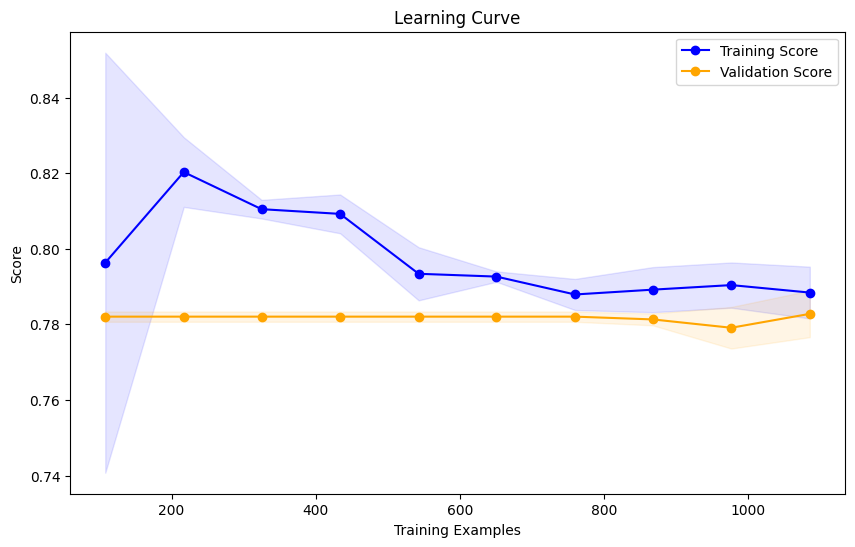

In [25]:
# Create the learning curve for the model and give a respond to if the model has overfitting or underffiting or it is a balanced model

# Define the training sizes for the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=SVM_classifier,
    X=X_train, y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 different training set sizes
    cv=5  # 5-fold cross-validation
)

# Calculate mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")

# Plot training scores with standard deviation
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1, color="blue")
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training Score")

# Plot validation scores with standard deviation
plt.fill_between(train_sizes,
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std,
                 alpha=0.1, color="orange")
plt.plot(train_sizes, val_scores_mean, 'o-', color="orange", label="Validation Score")

plt.legend(loc="best")
plt.show()

In [ ]:
# Use a method from scikit learn that allows to divide the entire dataset in custom train/test distribution (80/20)
# Load the CSV file into a pandas DataFrame
df = pd.read_csv('faults.csv')

# Assuming 'target_column' is the name of your target variable column
X = df[['Bumps']].copy()  # Features
y = df.copy().drop(columns=['Bumps'])  # Target variable

# Split the dataset into training and testing sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
print(100*len(X_train)/len(X))

# 5. Repeat the classification with another classifier

Let's make the classification with a different classifier: A Multilayer Perceptron (MLP), a.k.a., shallow neural network.

At this point, the training and test data are already loaded and preprocessed, so we only have to:
1. Instantiate the classifier
2. Train the classifier with the (normalized) training set
3. Classify the (normalized) test set samples
4. Calculate the results comparing the predictions with the real classes of the training set

In [27]:
# Other classifier (MLP)
from sklearn.neural_network import MLPClassifier

Our MLP will have a hidden layer with 100 neurons on it. The activation function will be the sigmoid function, and it will be trained during a maximum of 500 iterations

In [28]:
# mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), activation='logistic', random_state=1, max_iter=1500, learning_rate='adaptive')
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=500)

In [29]:
mlp_classifier.fit(X_train_norm, y_train)

MLPClassifier(max_iter=500)

In [30]:
y_test_assig_mlp = mlp_classifier.predict(X_test_norm)

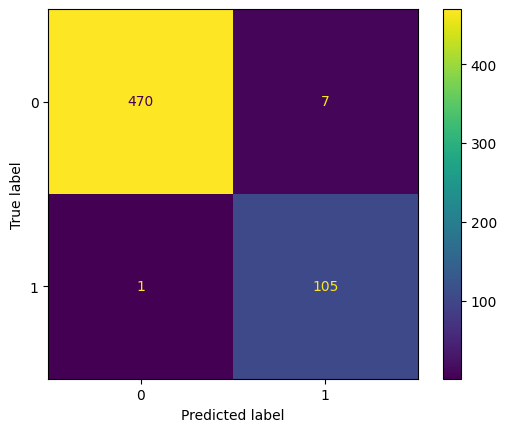

In [31]:
## Show CONFUSION MATRIX

cm = metrics.confusion_matrix(y_test, y_test_assig_mlp)
disp = metrics.ConfusionMatrixDisplay(cm)
disp.plot()
plt.show()

In [32]:
# Show a report with the classification results
# print(metrics.classification_report(y_test, y_test_assig, labels=(1,)))
print(metrics.classification_report(y_test, y_test_assig_mlp))

              precision    recall  f1-score   support

           0       1.00      0.99      0.99       477
           1       0.94      0.99      0.96       106

    accuracy                           0.99       583
   macro avg       0.97      0.99      0.98       583
weighted avg       0.99      0.99      0.99       583



In [33]:
TP = np.sum(np.logical_and(y_test == 1, y_test_assig_mlp == 1))
TN = np.sum(np.logical_and(y_test == 0, y_test_assig_mlp == 0))
FP = np.sum(np.logical_and(y_test == 0, y_test_assig_mlp == 1))
FN = np.sum(np.logical_and(y_test == 1, y_test_assig_mlp == 0))

accuracy = (TP + TN) / y_test.size
precision = TP / (TP + FP)
recall = TP / (TP + FN)
Fscore = (2 * precision * recall) / (precision + recall)

print("Accuracy: {}".format(accuracy))
print("Precision: {}".format(precision))
print("Recall: {}".format(recall))
print("F1-score: {}".format(Fscore))

Accuracy: 0.9862778730703259
Precision: 0.9375
Recall: 0.9905660377358491
F1-score: 0.963302752293578


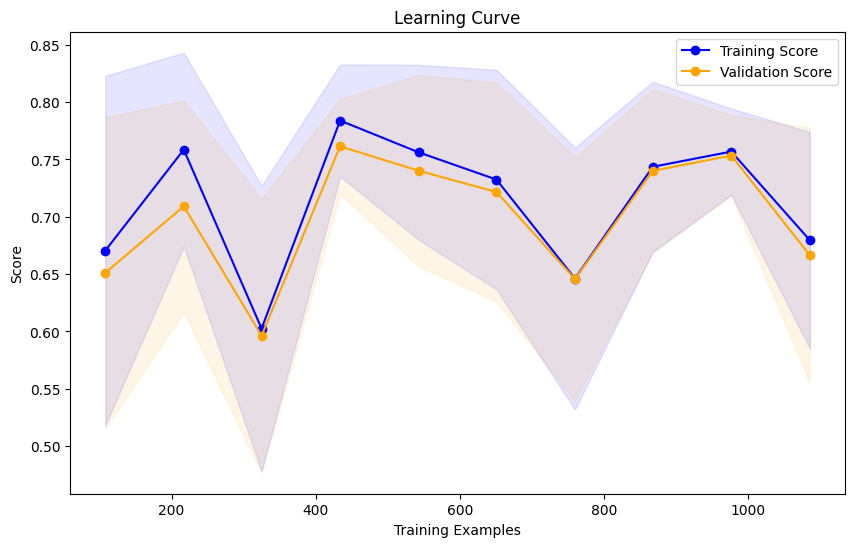

In [35]:
# Learning Curve
# Create the learning curve for the model and give a respond to if the model has overfitting or underffiting or it is a balanced model
mlp_classifier = MLPClassifier(hidden_layer_sizes=(100,), activation='relu', max_iter=500)

# Define the training sizes for the learning curve
train_sizes, train_scores, val_scores = learning_curve(
    estimator=mlp_classifier,
    X=X_train, y=y_train,
    train_sizes=np.linspace(0.1, 1.0, 10),  # 10 different training set sizes
    cv=5  # 5-fold cross-validation
)

# Calculate mean and standard deviation of training and validation scores
train_scores_mean = np.mean(train_scores, axis=1)
train_scores_std = np.std(train_scores, axis=1)
val_scores_mean = np.mean(val_scores, axis=1)
val_scores_std = np.std(val_scores, axis=1)

# Plot the learning curve
plt.figure(figsize=(10, 6))
plt.title("Learning Curve")
plt.xlabel("Training Examples")
plt.ylabel("Score")

# Plot training scores with standard deviation
plt.fill_between(train_sizes,
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std,
                 alpha=0.1, color="blue")
plt.plot(train_sizes, train_scores_mean, 'o-', color="blue", label="Training Score")

# Plot validation scores with standard deviation
plt.fill_between(train_sizes,
                 val_scores_mean - val_scores_std,
                 val_scores_mean + val_scores_std,
                 alpha=0.1, color="orange")
plt.plot(train_sizes, val_scores_mean, 'o-', color="orange", label="Validation Score")

plt.legend(loc="best")
plt.show()